# **Modeling Sale Price using Regression**

Part of CRISP-DM **Modelling** and **Evaluation**

## Objectives

* Fit and evaluate a regression model to predict sale prices of inherited houses
## Inputs

* outputs/datasets/collection/house_prices.csv
* Instructions on which variables to use for data cleaning and feature engineering, found in the respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* Feature Importance Plot


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [4]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [5]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [6]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

In [7]:
import numpy as np
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_prices.csv") 

print(df.shape)
df.head(3)

(1460, 24)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0       856     854.0           3.0           No         706          GLQ   
1      1262       0.0           3.0           Gd         978          ALQ   
2       920     866.0           3.0           Mn         486          GLQ   

   BsmtUnfSF  EnclosedPorch  GarageArea GarageFinish  ...  LotFrontage  \
0        150            0.0         548          RFn  ...         65.0   
1        284            NaN         460          RFn  ...         80.0   
2        434            0.0         608          RFn  ...         68.0   

   MasVnrArea OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  WoodDeckSF  \
0       196.0          61            5            7          856         0.0   
1         0.0           0            8            6         1262         NaN   
2       162.0          42            5            7          920         NaN   

   YearBuilt  YearRemodAdd  SalePrice  
0       2003          2003     208500  
1       1976          1976     181500  
2       2001          2002     223500  

[3 rows x 24 columns]

---

# ML Pipeline: Regression

### Create the ML Pipeline

In [8]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine import creation
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Pipeline optimization
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # Data Cleaning - see Data Cleaning Notebook
        ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch',
                                                  'WoodDeckSF']) ),
        ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage',
                                                'BedroomAbvGr']) ),
        ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['GarageYrBlt']) ),
        ( 'arbitrary', ArbitraryNumberImputer(arbitrary_number=0,
                                     variables=['2ndFlrSF',
                                                'MasVnrArea']) ),
        ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='Unf',
                                     variables=['GarageFinish',
                                                'BsmtFinType1']) ),

        # Feature Engineering - see Feature Engineering Notebook
        ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary',
                                            variables = ['BsmtExposure',
                                                         'BsmtFinType1',
                                                         'GarageFinish',
                                                         'KitchenQual'])),

        ('log_transformer', vt.LogTransformer(variables=['1stFlrSF',
                                                         'GrLivArea',
                                                         'LotArea',
                                                         'LotFrontage'],
                                                         base='e')),

        ('power_transformer', vt.PowerTransformer(variables=['BsmtUnfSF',
                                                             'MasVnrArea',
                                                             'OpenPorchSF',
                                                             'TotalBsmtSF'])),

        ('yeo_johnson_transformer', vt.YeoJohnsonTransformer(variables=['GarageArea'])),

        ('windsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                                    variables = ['GrLivArea',
                                                 'OpenPorchSF',
                                                 'TotalBsmtSF'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
            method="spearman", threshold=0.6, selection_method="variance")),
        
        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Custom Class for hyperparamter optimization

In [9]:
# Code from walkthrough project 02, modeling and evaluation notebook

from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 23) (1168,) 
* Test set: (292, 23) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [11]:
# Code from walkthrough project 02, modeling and evaluation notebook

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

We do a hyperparameter optimization search using default hyperparameters

In [12]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

We check the results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score
5  GradientBoostingRegressor  0.676866   0.780769  0.853509  0.065593
3        ExtraTreesRegressor  0.693332   0.769143  0.813026  0.046032
0           LinearRegression  0.704867   0.745475  0.815074  0.037108
2      RandomForestRegressor  0.578866   0.741709  0.822575  0.084435
6               XGBRegressor  0.610878   0.669282   0.70508  0.037976
4          AdaBoostRegressor  0.493132   0.633235  0.747121  0.101798
1      DecisionTreeRegressor  0.307376   0.507538  0.648469  0.127406

### We do an extensive search on the most suitable algorithm to find the best hyperparameter configuration.

We define model and parameters, for Extensive Search

In [14]:
# defining model parameters for a more extensive search

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# In a workplace project, you may consider more hyperparameters and spend more time in this step
# https://inria.github.io/scikit-learn-mooc/python_scripts/ensemble_hyperparameters.html

params_search = {
    "GradientBoostingRegressor": {
          'model__n_estimators': [50, 75, 100], # gives little improvements we stick to default = 100
          'model__max_depth': [3, 6, 9], # gives little improvement we stick to default = 3
          'model__learning_rate': [0.05, 0.1, 0.2], # This learning rate consistently gave the best r2 scores, default = 0.1
          # 'model__learning_rate': [0.05, 0.07, 0.1], # default = 0.1
          'model__min_samples_split': [2, 4, 8, 75], # setting this to 75 also gives very good results, but we will stick to the default = 2
          'model__min_samples_leaf': [1, 2, 8, 75], # changing this parameter also seems to cause slight overfitting - keep default = 1
          'model__max_leaf_nodes': [None, 25, 50, 75], # Changing this parameter seems to often cause slight overfitting - keep default = None
    }
}

Extensive GridSearch CV

In [15]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

We check the results

In [16]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score  \
729   GradientBoostingRegressor  0.735689   0.795535  0.845736  0.041426   
681   GradientBoostingRegressor  0.735689   0.795535  0.845736  0.041426   
633   GradientBoostingRegressor  0.735689   0.795535  0.845736  0.041426   
682   GradientBoostingRegressor  0.748306   0.795034  0.851872   0.03869   
634   GradientBoostingRegressor  0.748306   0.795034  0.851872   0.03869   
...                         ...       ...        ...       ...       ...   
961   GradientBoostingRegressor  0.454907   0.711544  0.803886  0.129602   
962   GradientBoostingRegressor  0.453974   0.711157  0.803126  0.129841   
1536  GradientBoostingRegressor   0.45633   0.701201  0.779159  0.123572   
1537  GradientBoostingRegressor   0.45485   0.700581  0.778842  0.123994   
1538  GradientBoostingRegressor  0.454461   0.700457  0.778685  0.124122   

     model__learning_rate model__max_depth model__max_leaf_nodes  \
729                   0.1                3                    75   
681                   0.1                3                    50   
633                   0.1                3                    25   
682                   0.1                3                    50   
634                   0.1                3                    25   
...                   ...              ...                   ...   
961                   0.1                9                  None   
962                   0.1                9                  None   
1536                  0.2                9                  None   
1537                  0.2                9                  None   
1538                  0.2                9                  None   

     model__min_samples_leaf model__min_samples_split model__n_estimators  
729                        1                       75                  50  
681                        1                       75                  50  
633                        1                       75                  50  
682                        1                       75                  75  
634                        1                       75                  75  
...                      ...                      ...                 ...  
961                        1                        2                  75  
962                        1                        2                 100  
1536                       1                        2                  50  
1537                       1                        2                  75  
1538                       1                        2                 100  

[1728 rows x 11 columns]

We get the best model name programmatically

In [17]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

We get the parameters for the best model

In [18]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': 25,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 75,
 'model__n_estimators': 50}

We define the best regressor pipeline

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('mean',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'BedroomAbvGr'])),
                ('median', MeanMedianImputer(variables=['GarageYrBlt'])),
                ('arbitrary',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'MasVnrArea'])),
                ('categorical',
                 Categ...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                           

## Assess feature importance

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 11 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps]).transform(X_train).columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', '2ndFlrSF', 'GarageArea']


## Evaluate on Train and Test Sets

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.savefig(f'docs/plots/regression_performance.png', bbox_inches='tight')  
  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.871
Mean Absolute Error: 19920.291
Mean Squared Error: 795480869.899
Root Mean Squared Error: 28204.27


* Test Set
R2 Score: 0.809
Mean Absolute Error: 22752.591
Mean Squared Error: 1317254106.967
Root Mean Squared Error: 36293.995




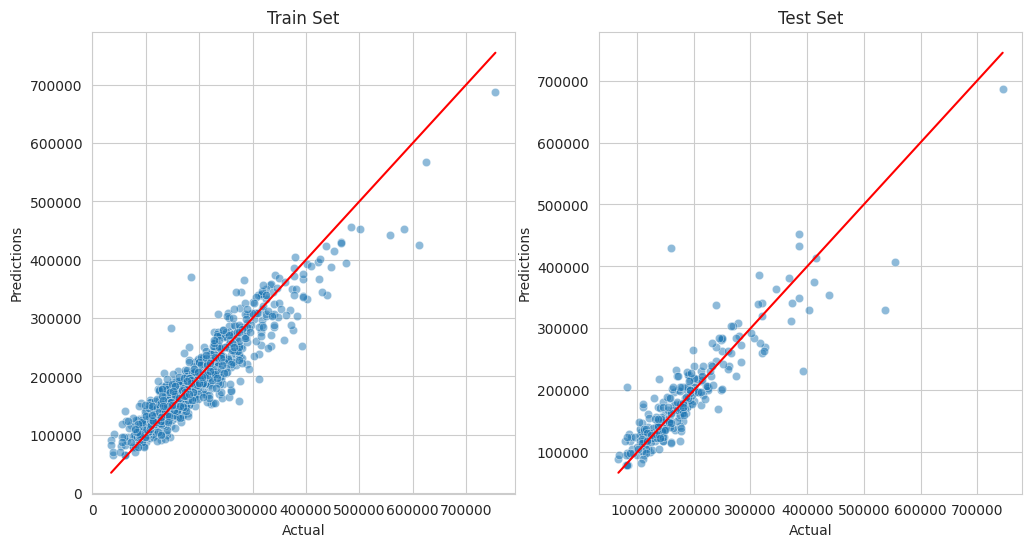

In [22]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

All data points follow the regression line nicely in both data sets. This model performance satisfies the business criteria of an R2 score of 0.75 or better.

## Refit pipeline with best features

### Rewrite Pipeline

We leave only the steps that affect the most important features identified by our analysis of the model, these are:
'OverallQual', 'TotalBsmtSF', '2ndFlrSF', and 'GarageArea'.

In [23]:
def PipelineOptimization(model):
    pipeline_base = Pipeline(steps=[

        # Data Cleaning - see Data Cleaning Notebook
        # ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch',
        #                                           'WoodDeckSF']) ),
        # ( 'mean',  MeanMedianImputer(imputation_method='mean',
        #                              variables=['LotFrontage',
        #                                         'BedroomAbvGr']) ),
        # ( 'median',  MeanMedianImputer(imputation_method='median',
        #                              variables=['GarageYrBlt']) ),
        ( 'arbitrary', ArbitraryNumberImputer(arbitrary_number=0,
                                     variables=['2ndFlrSF',
        #                                        'MasVnrArea'
                                                ]) ),
        # ( 'categorical',  CategoricalImputer(imputation_method='missing',
        #                              fill_value='Unf',
        #                              variables=['GarageFinish',
        #                                         'BsmtFinType1']) ),

        # Feature Engineering - see Feature Engineering Notebook
        # ('ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary',
        #                                     variables = ['BsmtExposure',
        #                                                  'BsmtFinType1',
        #                                                  'GarageFinish',
        #                                                  'KitchenQual'])),

        # ('log_transformer', vt.LogTransformer(variables=['1stFlrSF',
        #                                                  'GrLivArea',
        #                                                  'LotArea',
        #                                                  'LotFrontage'],
        #                                                  base='e')),

        ('power_transformer', vt.PowerTransformer(variables=[
        #                                                    'BsmtUnfSF',
        #                                                    'MasVnrArea',
        #                                                    'OpenPorchSF',
                                                             'TotalBsmtSF'])),

        ('yeo_johnson_transformer', vt.YeoJohnsonTransformer(variables=['GarageArea'])),

        ('windsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5,
                                    variables = [
        #                                        'GrLivArea',
        #                                        'OpenPorchSF',
                                                 'TotalBsmtSF'])),

        # ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        #     method="spearman", threshold=0.6, selection_method="variance")),
        
        # Feature Scaling
        ("scaler", StandardScaler()),

        # Feature Selection
        # ("feat_selection", SelectFromModel(model)),

        # ML Algorithms
        ("model", model),
    ])

    return pipeline_base

### Split Train Test Set, considering only with best features

In [24]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


2ndFlrSF  GarageArea  OverallQual  TotalBsmtSF
618       0.0         774            9         1822
870       0.0         308            5          894
92        0.0         432            5          876

We are using the same model from the last GridCV search

In [25]:
models_search # GradientBoostingRegressor

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

And the best parameters from the last GridCV search

In [26]:
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': 25,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 75,
 'model__n_estimators': 50}

In [27]:
params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [50],
        'model__max_depth': [3],
        'model__learning_rate': [0.1],
        'model__min_samples_split': [75],
        'model__min_samples_leaf': [1],
        'model__max_leaf_nodes': [25],
    }
}

In [28]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [29]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score  \
0  GradientBoostingRegressor  0.759553   0.800904   0.82681  0.026907   

  model__learning_rate model__max_depth model__max_leaf_nodes  \
0                  0.1                3                    25   

  model__min_samples_leaf model__min_samples_split model__n_estimators  
0                       1                       75                  50

In [30]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [31]:
# Defining the best pipeline

best_pipeline_regression = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regression

Pipeline(steps=[('arbitrary',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('power_transformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('yeo_johnson_transformer',
                 YeoJohnsonTransformer(variables=['GarageArea'])),
                ('windsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF'])),
                ('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(max_leaf_nodes=25,
                                           min_samples_split=75,
                                           n_estimators=50, random_state=0))])

---

# Push files to Repo

The following files will be created and pushed to the repo:

* Train Set
* Test Set
* Modeling Pipeline
* Feature importance Plot

In [32]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)
    

### Train Set: Features and Target

In [33]:
X_train.head()

2ndFlrSF  GarageArea  OverallQual  TotalBsmtSF
618       0.0         774            9         1822
870       0.0         308            5          894
92        0.0         432            5          876
817       0.0         857            8         1568
302       0.0         843            7         1541

In [34]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [35]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [36]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: Features and Target

In [37]:
X_test.head()

2ndFlrSF  GarageArea  OverallQual  TotalBsmtSF
529       0.0         484            6         2035
491     620.0         240            6          806
459     224.0         352            5          709
279     866.0         505            7         1160
655       NaN         264            6          525

In [38]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [39]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [40]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling Pipeline

In [41]:

best_pipeline_regression

Pipeline(steps=[('arbitrary',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('power_transformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('yeo_johnson_transformer',
                 YeoJohnsonTransformer(variables=['GarageArea'])),
                ('windsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['TotalBsmtSF'])),
                ('scaler', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(max_leaf_nodes=25,
                                           min_samples_split=75,
                                           n_estimators=50, random_state=0))])

In [42]:
joblib.dump(value=best_pipeline_regression, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/regression_pipeline.pkl']

### Feature Importance Plot

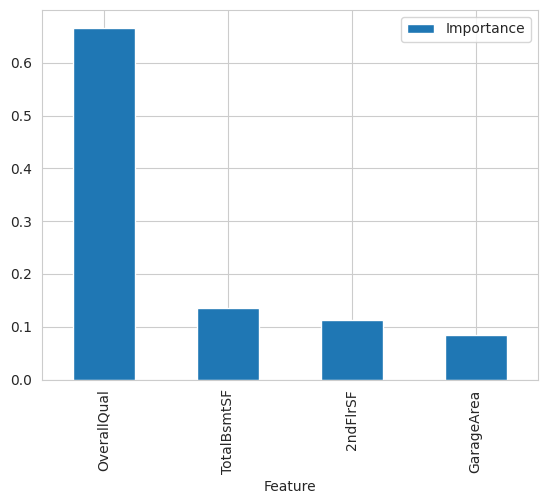

In [43]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

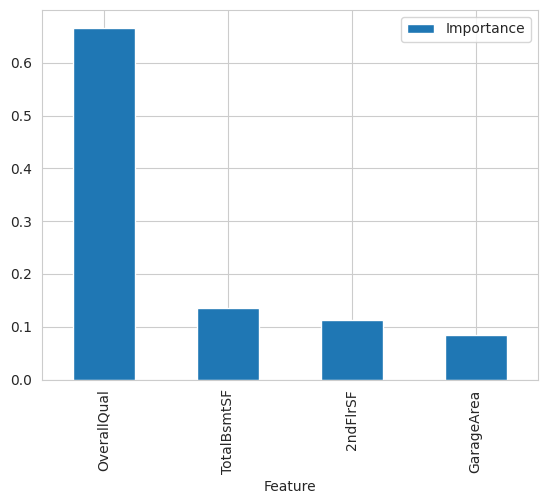

In [44]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')
## Save to docs folder for documentation
plt.savefig(f'docs/plots/features_importance.png', bbox_inches='tight') 